# IBM Data Science Capstone Project - Battle of the Neighborhoods

### I. Introduction:

**<u>A Changing Healthcare Landscape:</u>**

Healthcare delivery models are undergoing substantial changes given evolving reimbursement structures.  As part of this process, patients are increasingly responsible for making financial decisions about their own health care as ever larger portions of healthcare costs are now the responsibility of the individual patient.   Consequently, individuals seeking health services are acting more and more like consumers of other types of goods and services, particularly when it comes to drivers such as quality and convenience. <br><br>
To meet the demands of savvy health consumers, in the past decade there has been a precipitous rise in so-called “doc-in-a-box” clinics and urgent-care centers which operate differently than either the traditional physician office or the acute-care hospital emergency room. <br><br>
Increasingly, understanding healthcare access within communities is a critical component to planning.  Public health officials, along with health plan and hospital administrators, and physician practice managers will want to understand the healthcare resources better as they plan for their own access needs.  Especially with recent development of COVID-19, there has been an increased awareness around how interconnected health services are to each other. <br><br>
This project intends to use Foursquare API technology to better understand the types of healthcare resources that are available within one metropolitan city that was particularly impacted by COVID-19 - Seattle, Washington. 

### II. Data Sources

This analysis uses zip code and neighborhood data pulled from the Seattle zip codes website (http://seattlearea.com/zip-codes/) along with Seattle.gov to create a neighborhood zip code mapping.  <br><br>
Based on this mapping, a keyword query based on "nursing facilities" was completed using the Foursquare API. 

#### 1) To start, I import appropriate libraries including pandas, numpy, matplotlib, json, geopy, and folium amongst others to allow for certain functionality. 

In [49]:
# main libraries for use:
import pandas as pd
import numpy as np
import json
import matplotlib
!pip install lxml
!pip install beautifulsoup4
import csv

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import requests # library to handle requests
from pandas.io.json import json_normalize 

#geopy library and folium library:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium 

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

print('Libraries imported.')


Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Data relating to neighborhoods in the two cities was found in a PDF file via Seattle.gov. PDF files are notoriously difficult to scrape, so a csv file was created in Excel and this file is then read in to create the dataframe "df_zip". 

In [36]:
with open('Seattle_Neighborhood_Zips2.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    zipcode_list = []
    for row in reader:
        zipcode_list.append(row)

In [37]:
zipcode_list.pop(0)
zipcode_list

[['98003', ' Federal Way, WA'],
 ['98005', ' Bellevue, WA'],
 ['98037', ' Lynnwood, WA'],
 ['98040', ' Mercer Island, WA'],
 ['98052', ' Redmond, WA'],
 ['98055', ' Renton, WA'],
 ['98101', ' Seattle, WA'],
 ['98101', ' Downtown Seattle, WA'],
 ['98102', ' Capital Hill Seattle, WA'],
 ['98103', ' Greenwood, WA'],
 ['98103', ' Fremont Seattle, WA'],
 ['98103', ' Greenlake, WA'],
 ['98104', ' Seattle Chinatown - international District, WA'],
 ['98104', ' Pioneer Square, WA'],
 ['98105', ' University District, WA'],
 ['98105', ' Laurelhurst, WA'],
 ['98107', ' Ballard, WA'],
 ['98109', ' South Lake Union, WA'],
 ['98109', ' Queen Anne, WA'],
 ['98110', ' Bainbridge Island, WA'],
 ['98110', ' Madrona, WA'],
 ['98116', ' West Seattle, WA'],
 ['98116', ' Alki Beach, WA'],
 ['98118', ' Columbia City, WA'],
 ['98121', ' Belltown, WA'],
 ['98125', ' Northgate, WA'],
 ['98144', ' Mount Baker Seattle, WA'],
 ['98199', ' Magnolia Seattle, WA'],
 ['98031', ' Kent, WA'],
 ['98188', ' Tukwila, WA']]

### Define Foursquare Client Connection:

##### In this case we will assign a LIMIT of 100

In [38]:
CLIENT_ID = 'M4CDQNDGONDDCYDKOZGUFEGINFNFAQDGGO5XRVFKLLYDSZUL' # your Foursquare ID
CLIENT_SECRET = '3DTEVCMIHSLQ1TFHNGH44VBHMSPP2V4N420WV5W1RJVCFJNY' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: M4CDQNDGONDDCYDKOZGUFEGINFNFAQDGGO5XRVFKLLYDSZUL
CLIENT_SECRET:3DTEVCMIHSLQ1TFHNGH44VBHMSPP2V4N420WV5W1RJVCFJNY


### For purposes of this project, we will start by considering the primary city center of Seattle, Washington.

In [39]:
address = 'Seattle Chinatown - International District, WA'

geolocator = Nominatim(user_agent="seattle_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(" The geographical coordinates of Seattle, WA are {}, {}.".format(latitude, longitude))

 The geographical coordinates of Seattle, WA are 47.6028956, -122.3398408.


#### Update the dataframe df_zip to include latitudes and longitudes:

#### Use GeoPy to get the latitude and longitude of each of the neighborhoods. 

In [47]:
zipcode_main=[]
for zipcode in zipcode_list:
    address = zipcode[1]
    geolocator = Nominatim(user_agent="seattle_explorer")
    location = geolocator.geocode(address)

    zipcode_main.append([zipcode[0], zipcode[1], location.latitude, location.longitude])
    

In [48]:
zipcode_main

[['98003', ' Federal Way, WA', 47.313494, -122.3393103],
 ['98005', ' Bellevue, WA', 47.6144219, -122.1923372],
 ['98037', ' Lynnwood, WA', 47.8278656, -122.3053932],
 ['98040', ' Mercer Island, WA', 47.5602073, -122.22014226861951],
 ['98052', ' Redmond, WA', 47.6694141, -122.1238767],
 ['98055', ' Renton, WA', 47.4799078, -122.2034496],
 ['98101', ' Seattle, WA', 47.6038321, -122.3300624],
 ['98101', ' Downtown Seattle, WA', 47.6048723, -122.3334582],
 ['98102', ' Capital Hill Seattle, WA', 47.6082635, -122.3351896],
 ['98103', ' Greenwood, WA', 47.6909806, -122.3548773],
 ['98103', ' Fremont Seattle, WA', 47.6504529, -122.3499861],
 ['98103', ' Greenlake, WA', 47.671350450000006, -122.34388239952041],
 ['98104',
  ' Seattle Chinatown - international District, WA',
  47.6028956,
  -122.3398408],
 ['98104', ' Pioneer Square, WA', 47.60213935, -122.33392745045508],
 ['98105', ' University District, WA', 47.6612984, -122.3131523],
 ['98105', ' Laurelhurst, WA', 47.6634317, -122.2770698]

### Create a dataframe based on this list:

In [9]:
df_zipcode = pd.DataFrame(zipcode_main, columns = ['Zip Code', 'Neighborhood', 'Latitude', 'Longitude'])

In [10]:
df_zipcode.head(10)

,Zip Code,Neighborhood,Latitude,Longitude
0,98003,"Federal Way, WA",47.313494,-122.339310
1,98005,"Bellevue, WA",47.614422,-122.192337
2,98037,"Lynnwood, WA",47.827866,-122.305393
3,98040,"Mercer Island, WA",47.560207,-122.220142
4,98052,"Redmond, WA",47.669414,-122.123877
5,98055,"Renton, WA",47.479908,-122.203450
6,98101,"Seattle, WA",47.603832,-122.330062
7,98101,"Downtown Seattle, WA",47.604872,-122.333458
8,98102,"Capital Hill Seattle, WA",47.608263,-122.335190
9,98103,"Greenwood, WA",47.690981,-122.354877


In [11]:
df_zipcode.shape

(30, 4)

### Let's map the various Seattle Neighborhoods in Folium:

In [12]:
# create map of Seattle using latitude and longitude values
map_seattle = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in list(zip(df_zipcode['Latitude'], df_zipcode['Longitude'], df_zipcode['Neighborhood'])):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_seattle)  
    
map_seattle

## Now look at the Foursquare data:

## Search for a specific venue category
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

#### 1) Begin with the query:

#### 2) Next, create the Fourssquare URL instance which will correspond to the search query just stated. <br><br> For the purposes of this project, the primary focus is on health services in the described region.  The search criteria will consider an approximate 1 mi radius and use a search keyword querying on the phrase "health services". 

In [13]:
neighborhood_latitude = df_zipcode.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_zipcode.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_zipcode.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of  Federal Way, WA are 47.313494, -122.3393103.


In [14]:
LIMIT = 100
RADIUS = 3000
search_query = 'health services'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude,
    RADIUS, 
    LIMIT,
    search_query)
url


'https://api.foursquare.com/v2/venues/explore?&client_id=M4CDQNDGONDDCYDKOZGUFEGINFNFAQDGGO5XRVFKLLYDSZUL&client_secret=3DTEVCMIHSLQ1TFHNGH44VBHMSPP2V4N420WV5W1RJVCFJNY&v=20180604&ll=47.313494,-122.3393103&radius=3000&limit=100&query=health services'

#### 3) Utilize the GET request function (from the imported requests library) and assign to a results object.

In [15]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef7d6c627946d5a149053ba'},
 'response': {'warning': {'text': 'There aren\'t a lot of results for "health services." Try something more general, reset your filters, or expand the search area.'},
  'headerLocation': 'Federal Way',
  'headerFullLocation': 'Federal Way',
  'headerLocationGranularity': 'city',
  'query': 'health services',
  'totalResults': 0,
  'suggestedBounds': {'ne': {'lat': 47.34049402700003,
    'lng': -122.29956081802194},
   'sw': {'lat': 47.28649397299997, 'lng': -122.37905978197804}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': []}]}}

#### 4) In this instance the criteria was too restrictive.   A different approach needs to be taken.  Refining, let us consider a single keyword for the query search defined simply as "healthcare". 

In [16]:
LIMIT = 100
RADIUS = 3000
search_query = 'healthcare'

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude,
    RADIUS, 
    LIMIT,
    search_query)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef7d5ed4f30dd22c536aa18'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Federal Way',
  'headerFullLocation': 'Federal Way',
  'headerLocationGranularity': 'city',
  'query': 'healthcare',
  'totalResults': 191,
  'suggestedBounds': {'ne': {'lat': 47.34049402700003,
    'lng': -122.29956081802194},
   'sw': {'lat': 47.28649397299997, 'lng': -122.37905978197804}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b74b69bf964a5200cee2de3',
       'name': 'Virginia Mason Federal Way Medical Center',
       'location': {'address': '33501 First Way S.',
        'lat': 47.30034973344131,
        'lng': -122.3306343372828,
        'labeledLatLngs': 

#### Define the categories function which will allow us to filter results more succinctly.   Then complete the filtration.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [18]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Virginia Mason Federal Way Medical Center,Medical Center,47.300350,-122.330634
1,Group Health Medical Center,Medical Center,47.314188,-122.331552
2,Brookdale Foundation House,Assisted Living,47.312572,-122.332442
3,SYNERGY HomeCare,Medical Center,47.303722,-122.329826
4,Restoration Health Services,Medical Center,47.302976,-122.331278


In [19]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


#### 

#### 5) This was a far more comprehensive result space and is limited by the limit of 100. <br> <br> Following the same approach, a search can be performed for the other Seattle neighborhoods.

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    QUERY_DEFINED = 'healthcare'
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            QUERY_DEFINED)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
seattle_healthcare = getNearbyVenues(names=df_zipcode['Neighborhood'],
                                   latitudes=df_zipcode['Latitude'],
                                   longitudes=df_zipcode['Longitude']
                                  )

 Federal Way, WA
 Bellevue, WA
 Lynnwood, WA
 Mercer Island, WA
 Redmond, WA
 Renton, WA
 Seattle, WA
 Downtown Seattle, WA
 Capital Hill Seattle, WA
 Greenwood, WA
 Fremont Seattle, WA
 Greenlake, WA
 Seattle Chinatown - international District, WA
 Pioneer Square, WA
 University District, WA
 Laurelhurst, WA
 Ballard, WA
 South Lake Union, WA
 Queen Anne, WA
 Bainbridge Island, WA
 Madrona, WA
 West Seattle, WA
 Alki Beach, WA
 Columbia City, WA
 Belltown, WA
 Northgate, WA
 Mount Baker Seattle, WA
 Magnolia Seattle, WA
 Kent, WA
 Tukwila, WA


In [22]:
print(seattle_healthcare.shape)
seattle_healthcare.head(35)

(845, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Federal Way, WA",47.313494,-122.339310,Federal Way Pediatric Associates,47.314083,-122.334684,Medical Center
1,"Federal Way, WA",47.313494,-122.339310,Federal Way Pediatric Cardiology,47.313728,-122.333450,Doctor's Office
2,"Federal Way, WA",47.313494,-122.339310,Federal Way Pediatric Associates,47.313728,-122.333450,Doctor's Office
3,"Federal Way, WA",47.313494,-122.339310,"Sutton, Alex DDS",47.314017,-122.335375,Dentist's Office
4,"Federal Way, WA",47.313494,-122.339310,Federal Way Children's Dentistry,47.314017,-122.335375,Dentist's Office
5,"Federal Way, WA",47.313494,-122.339310,West Campus Dental Center,47.314076,-122.335345,Dentist's Office
6,"Federal Way, WA",47.313494,-122.339310,Meridian Dental Clinic,47.313975,-122.334011,Dentist's Office
7,"Federal Way, WA",47.313494,-122.339310,Meridian Dental Clinic Federal Way,47.313934,-122.333998,Dentist's Office
8,"Federal Way, WA",47.313494,-122.339310,"Edgar Dentistry, DDS",47.313893,-122.333938,Dentist's Office
9,"Federal Way, WA",47.313494,-122.339310,Nordlie's Family Dentistry,47.314606,-122.333885,Dentist's Office


#### 6) Looking at venue counts by Seattle neighborhood:

In [23]:
seattle_healthcare.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Alki Beach, WA",2,2,2,2,2,2
"Bainbridge Island, WA",21,21,21,21,21,21
"Ballard, WA",4,4,4,4,4,4
"Bellevue, WA",53,53,53,53,53,53
"Belltown, WA",53,53,53,53,53,53
"Capital Hill Seattle, WA",100,100,100,100,100,100
"Columbia City, WA",13,13,13,13,13,13
"Downtown Seattle, WA",100,100,100,100,100,100
"Federal Way, WA",14,14,14,14,14,14


In [24]:
print('There are {} uniques categories.'.format(len(seattle_healthcare['Venue Category'].unique())))

There are 29 uniques categories.


#### 7) It will also help to understand what venue type is dominating the analysis.  Grouping by the venue catagory and sorting in descending order:

In [25]:
df_sea_venue = seattle_healthcare.groupby('Venue Category').count()
df_sea_venue.drop(['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue Latitude', 'Venue Longitude'], axis=1, inplace=True)
df_sea_venue = df_sea_venue.sort_values(by=['Venue'], ascending = False)
df_sea_venue

,Venue
Venue Category,
Doctor's Office,426
Dentist's Office,105
Medical Center,97
Chiropractor,55
Acupuncturist,30
Physical Therapist,21
Mental Health Office,20
Hospital,15
Eye Doctor,14


#### 8) Clearly doctor and dentist offices are by far the most common.  Suprisingly, there are only 2 urgent care centers in the result set from Foursquare.  Which seems quite quite small given current changes in the health marketplace where stand alone non emergency department care sites and "doc-in-the-box" establishments are becoming increasingly common.   Perhaps this suggests that the labeling conventions used in Foursquare could be better refined for the healthcare space? <br><br> It may be useful to help visualize this data more fully by consolidating the venue catagories that are quite small and then using a pie chart. 

In [26]:
#Consider only the top 10 venue catagories for the pie chart:
df_sea_venue_top10 = df_sea_venue.drop(df_sea_venue.index[[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]])


In [27]:
df_sea_venue_top10

,Venue
Venue Category,
Doctor's Office,426
Dentist's Office,105
Medical Center,97
Chiropractor,55
Acupuncturist,30
Physical Therapist,21
Mental Health Office,20
Hospital,15
Eye Doctor,14


In [28]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

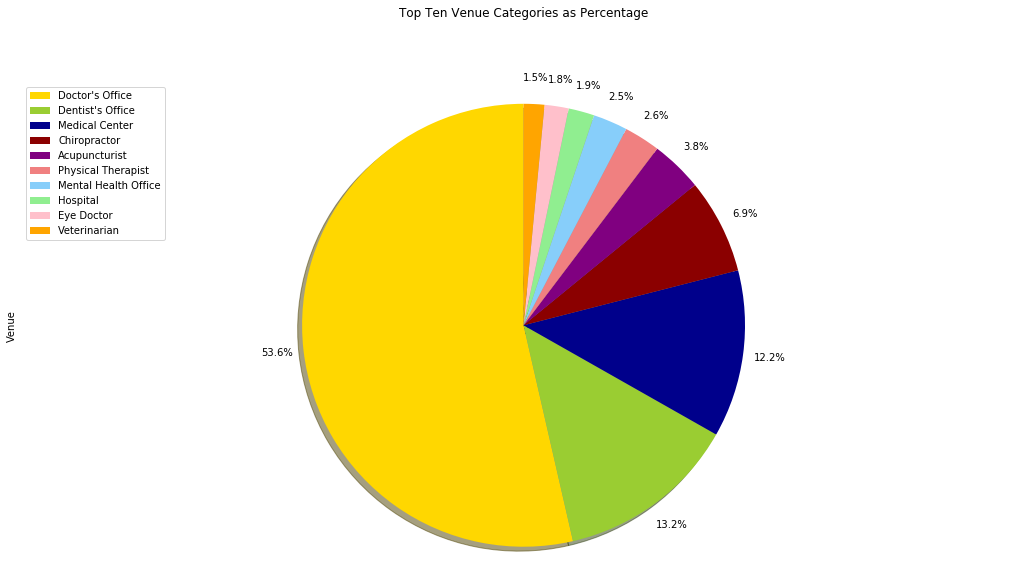

In [29]:
colors_list = ['gold', 'yellowgreen', 'darkblue', 'darkred', 'purple', 'lightcoral', 'lightskyblue', 'lightgreen', 'pink', 'orange']

df_sea_venue_top10['Venue'].plot(kind='pie',
                            figsize=(18, 9),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            )

# scale the title up by 12% to match pctdistance
plt.title('Top Ten Venue Categories as Percentage', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=df_sea_venue_top10.index, loc='upper left') 

plt.show()

## Analyze each neighborhood:

Start by using one hot encoding to 

In [30]:
# one hot encoding
seattle_onehot = pd.get_dummies(seattle_healthcare[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
seattle_onehot['Neighborhood'] = seattle_healthcare['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [seattle_onehot.columns[-1]] + list(seattle_onehot.columns[:-1])
seattle_onehot = seattle_onehot[fixed_columns]

seattle_onehot.head(10)

,Neighborhood,Acupuncturist,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office,Doctor's Office,Emergency Room,...,Medical Lab,Mental Health Office,Nutritionist,Office,Optical Shop,Pharmacy,Physical Therapist,Rehab Center,Urgent Care Center,Veterinarian
0,"Federal Way, WA",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Federal Way, WA",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"Federal Way, WA",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Federal Way, WA",0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Considering the overall dataframe size:

In [31]:
seattle_onehot.shape

(845, 30)

In [32]:
seattle_grouped = seattle_onehot.groupby('Neighborhood').mean().reset_index()
seattle_grouped

,Neighborhood,Acupuncturist,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office,Doctor's Office,Emergency Room,...,Medical Lab,Mental Health Office,Nutritionist,Office,Optical Shop,Pharmacy,Physical Therapist,Rehab Center,Urgent Care Center,Veterinarian
0,"Alki Beach, WA",0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Bainbridge Island, WA",0.095238,0.000000,0.000000,0.000000,0.047619,0.000000,0.142857,0.666667,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Ballard, WA",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"Bellevue, WA",0.000000,0.018868,0.000000,0.000000,0.075472,0.000000,0.132075,0.566038,0.00,...,0.018868,0.018868,0.000000,0.000000,0.018868,0.000000,0.037736,0.000000,0.018868,0.018868
4,"Belltown, WA",0.037736,0.037736,0.000000,0.000000,0.132075,0.000000,0.188679,0.226415,0.00,...,0.000000,0.094340,0.018868,0.000000,0.000000,0.000000,0.018868,0.000000,0.000000,0.037736
5,"Capital Hill Seattle, WA",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.870000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000
6,"Columbia City, WA",0.307692,0.000000,0.000000,0.000000,0.000000,0.000000,0.384615,0.076923,0.00,...,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923
7,"Downtown Seattle, WA",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.830000,0.00,...,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,"Federal Way, WA",0.071429,0.000000,0.000000,0.000000,0.071429,0.071429,0.500000,0.142857,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Fremont Seattle, WA",0.179487,0.025641,0.000000,0.000000,0.128205,0.000000,0.076923,0.230769,0.00,...,0.000000,0.051282,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000


In [33]:
seattle_grouped.shape

(30, 30)

#### Printing each neighborhood along with the top 5 most common medical center venues.

In [34]:
num_top_venues = 5

for hood in seattle_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = seattle_grouped[seattle_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Alki Beach, WA----
                venue  freq
0     Doctor's Office   0.5
1  Alternative Healer   0.5
2       Acupuncturist   0.0
3      Massage Studio   0.0
4  Urgent Care Center   0.0


---- Bainbridge Island, WA----
              venue  freq
0   Doctor's Office  0.67
1  Dentist's Office  0.14
2     Acupuncturist  0.10
3      Chiropractor  0.05
4    Medical Center  0.05


---- Ballard, WA----
                  venue  freq
0      Dentist's Office  0.75
1        Massage Studio  0.25
2         Acupuncturist  0.00
3  Marijuana Dispensary  0.00
4    Urgent Care Center  0.00


---- Bellevue, WA----
                venue  freq
0     Doctor's Office  0.57
1    Dentist's Office  0.13
2        Chiropractor  0.08
3  Physical Therapist  0.04
4      Medical Center  0.04


---- Belltown, WA----
                  venue  freq
0       Doctor's Office  0.23
1      Dentist's Office  0.19
2        Medical Center  0.13
3          Chiropractor  0.13
4  Mental Health Office  0.09


---- Capital Hill 

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Now let's create the new dataframe and display the top 10 healthcare facility results for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = seattle_grouped['Neighborhood']

for ind in np.arange(seattle_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(seattle_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(35)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Alki Beach, WA",Alternative Healer,Doctor's Office,Veterinarian,Hospital Ward,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office,Emergency Room
1,"Bainbridge Island, WA",Doctor's Office,Dentist's Office,Acupuncturist,Chiropractor,Medical Center,Hospital Ward,Alternative Healer,Assisted Living,Building,Daycare
2,"Ballard, WA",Dentist's Office,Massage Studio,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office
3,"Bellevue, WA",Doctor's Office,Dentist's Office,Chiropractor,Medical Center,Physical Therapist,Veterinarian,Hospital,Urgent Care Center,Medical Lab,Mental Health Office
4,"Belltown, WA",Doctor's Office,Dentist's Office,Chiropractor,Medical Center,Mental Health Office,Eye Doctor,Veterinarian,Alternative Healer,Acupuncturist,Marijuana Dispensary
5,"Capital Hill Seattle, WA",Doctor's Office,Medical Center,Optical Shop,Veterinarian,Hospital,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare
6,"Columbia City, WA",Dentist's Office,Acupuncturist,Mental Health Office,Doctor's Office,Maternity Clinic,Veterinarian,Office,Financial or Legal Service,Alternative Healer,Assisted Living
7,"Downtown Seattle, WA",Doctor's Office,Medical Center,Office,Veterinarian,Hospital,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare
8,"Federal Way, WA",Dentist's Office,Doctor's Office,Acupuncturist,Chiropractor,Daycare,Medical Center,Eye Doctor,Hospital Ward,Alternative Healer,Assisted Living
9,"Fremont Seattle, WA",Doctor's Office,Acupuncturist,Medical Center,Chiropractor,Physical Therapist,Dentist's Office,Mental Health Office,Health & Beauty Service,Alternative Healer,Marijuana Dispensary


#### Next, an unlabeled k-means technique will be used to group the neighborhoods into similar clusters.

In [37]:
# set number of clusters
kclusters = 5

seattle_grouped_clustering = seattle_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=2).fit(seattle_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 1, 2, 0, 2, 4, 2, 4, 0], dtype=int32)

In [38]:
print(kmeans.labels_)

[2 2 1 2 0 2 4 2 4 0 3 0 0 0 4 4 1 1 4 4 0 0 4 4 0 2 0 0 0 2]


In [39]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', (kmeans.labels_))

seattle_merged = df_zipcode

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
seattle_merged = seattle_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

seattle_merged.head() # check the last columns!

,Zip Code,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,98003,"Federal Way, WA",47.313494,-122.339310,4,Dentist's Office,Doctor's Office,Acupuncturist,Chiropractor,Daycare,Medical Center,Eye Doctor,Hospital Ward,Alternative Healer,Assisted Living
1,98005,"Bellevue, WA",47.614422,-122.192337,2,Doctor's Office,Dentist's Office,Chiropractor,Medical Center,Physical Therapist,Veterinarian,Hospital,Urgent Care Center,Medical Lab,Mental Health Office
2,98037,"Lynnwood, WA",47.827866,-122.305393,4,Dentist's Office,Veterinarian,Doctor's Office,Chiropractor,Acupuncturist,Optical Shop,Office,Alternative Healer,Assisted Living,Building
3,98040,"Mercer Island, WA",47.560207,-122.220142,1,Dentist's Office,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office,Emergency Room
4,98052,"Redmond, WA",47.669414,-122.123877,4,Dentist's Office,Physical Therapist,Doctor's Office,Veterinarian,Medical Center,Chiropractor,Acupuncturist,Eye Doctor,Optical Shop,Hospital


#### Mapping the clusters:

In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(seattle_merged['Latitude'], seattle_merged['Longitude'], seattle_merged['Neighborhood'], seattle_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Examining the clusters:

##### Cluster 1:

In [41]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 0, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Greenwood, WA",Doctor's Office,Medical Center,Physical Therapist,Dentist's Office,Veterinarian,Chiropractor,Building,Massage Studio,Maternity Clinic,Acupuncturist
10,"Fremont Seattle, WA",Doctor's Office,Acupuncturist,Medical Center,Chiropractor,Physical Therapist,Dentist's Office,Mental Health Office,Health & Beauty Service,Alternative Healer,Marijuana Dispensary
12,"Seattle Chinatown - international District, WA",Doctor's Office,Chiropractor,Dentist's Office,Mental Health Office,Medical Center,Veterinarian,Hospital,Alternative Healer,Assisted Living,Building
13,"Pioneer Square, WA",Doctor's Office,Chiropractor,Dentist's Office,Medical Center,Mental Health Office,Physical Therapist,Eye Doctor,Acupuncturist,Health & Beauty Service,Medical Lab
14,"University District, WA",Doctor's Office,Dentist's Office,Medical Center,Chiropractor,Acupuncturist,Physical Therapist,Hospital,Marijuana Dispensary,Medical Lab,Mental Health Office
15,"Laurelhurst, WA",Hospital,Doctor's Office,Medical Center,Hospital Ward,Laboratory,Medical Lab,Emergency Room,Eye Doctor,Alternative Healer,Assisted Living
17,"South Lake Union, WA",Doctor's Office,Dentist's Office,Chiropractor,Medical Lab,Medical Center,Eye Doctor,Veterinarian,Hospital,Office,Alternative Healer
18,"Queen Anne, WA",Doctor's Office,Dentist's Office,Chiropractor,Acupuncturist,Physical Therapist,Eye Doctor,Hospital Ward,Alternative Healer,Assisted Living,Building
24,"Belltown, WA",Doctor's Office,Dentist's Office,Chiropractor,Medical Center,Mental Health Office,Eye Doctor,Veterinarian,Alternative Healer,Acupuncturist,Marijuana Dispensary
28,"Kent, WA",Dentist's Office,Doctor's Office,Medical Center,Laboratory,Chiropractor,Hospital Ward,Alternative Healer,Assisted Living,Building,Daycare


##### Cluster 2:

In [42]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 1, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"Mercer Island, WA",Dentist's Office,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office,Emergency Room
16,"Ballard, WA",Dentist's Office,Massage Studio,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office
27,"Magnolia Seattle, WA",Dentist's Office,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office,Emergency Room


##### Cluster 3:

In [43]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 2, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Bellevue, WA",Doctor's Office,Dentist's Office,Chiropractor,Medical Center,Physical Therapist,Veterinarian,Hospital,Urgent Care Center,Medical Lab,Mental Health Office
6,"Seattle, WA",Doctor's Office,Medical Center,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office
7,"Downtown Seattle, WA",Doctor's Office,Medical Center,Office,Veterinarian,Hospital,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare
8,"Capital Hill Seattle, WA",Doctor's Office,Medical Center,Optical Shop,Veterinarian,Hospital,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare
19,"Bainbridge Island, WA",Doctor's Office,Dentist's Office,Acupuncturist,Chiropractor,Medical Center,Hospital Ward,Alternative Healer,Assisted Living,Building,Daycare
21,"West Seattle, WA",Doctor's Office,Dentist's Office,Acupuncturist,Medical Center,Chiropractor,Medical Lab,Alternative Healer,Physical Therapist,Hospital,Assisted Living
22,"Alki Beach, WA",Alternative Healer,Doctor's Office,Veterinarian,Hospital Ward,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office,Emergency Room


##### Cluster 4:

In [44]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 3, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"Greenlake, WA",Physical Therapist,Hospital,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Dentist's Office


##### Cluster 5:

In [45]:
seattle_merged.loc[seattle_merged['Cluster Labels'] == 4, seattle_merged.columns[[1] + list(range(5, seattle_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Federal Way, WA",Dentist's Office,Doctor's Office,Acupuncturist,Chiropractor,Daycare,Medical Center,Eye Doctor,Hospital Ward,Alternative Healer,Assisted Living
2,"Lynnwood, WA",Dentist's Office,Veterinarian,Doctor's Office,Chiropractor,Acupuncturist,Optical Shop,Office,Alternative Healer,Assisted Living,Building
4,"Redmond, WA",Dentist's Office,Physical Therapist,Doctor's Office,Veterinarian,Medical Center,Chiropractor,Acupuncturist,Eye Doctor,Optical Shop,Hospital
5,"Renton, WA",Dentist's Office,Chiropractor,Mental Health Office,Medical Lab,Medical Center,Veterinarian,Alternative Healer,Doctor's Office,Hospital,Assisted Living
20,"Madrona, WA",Dentist's Office,Acupuncturist,Alternative Healer,Mental Health Office,Hospital Ward,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office
23,"Columbia City, WA",Dentist's Office,Acupuncturist,Mental Health Office,Doctor's Office,Maternity Clinic,Veterinarian,Office,Financial or Legal Service,Alternative Healer,Assisted Living
25,"Northgate, WA",Dentist's Office,Chiropractor,Medical Center,Mental Health Office,Doctor's Office,Veterinarian,Alternative Healer,Assisted Living,Acupuncturist,Medical Lab
26,"Mount Baker Seattle, WA",Physical Therapist,Dentist's Office,Veterinarian,Hospital Ward,Alternative Healer,Assisted Living,Building,Chiropractor,Daycare,Doctor's Office


# Second Part of Analysis Tools - Considering Hospital Charges by Payor

In [46]:
!conda install -c anaconda xlrd --yes

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - xlrd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.1.1   |                0         132 KB  anaconda
    certifi-2020.6.20          |           py36_0         160 KB  anaconda
    openssl-1.1.1g             |       h7b6447c_0         3.8 MB  anaconda
    xlrd-1.2.0                 |           py36_0         188 KB  anaconda
    ------------------------------------------------------------
                                           Total:         4.3 MB

The following packages will be SUPERSEDED by a higher-priority channel:

  ca-certificates    conda-forge::ca-certificates-2020.6.2~ --> anaconda::ca-certificates-2020.1.1-0
  certifi            conda-forge::certifi-2020.6.20-py36h9~ --> anaconda::certifi-2020.6.20-py36_0
  opens

In [48]:
%%capture
! pip install seaborn

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [50]:
df_hospitals = pd.read_excel(open('2019HospitalCensusChargeByPayor.xlsx','rb'))

In [51]:
df_hospitals.columns=['Hospital_name', 'Type', 'Lic', 'payername', 'Discharges', 'Total_days', 'Total_charges', 'Mean_LOS', 'Mean_Charge_per_Discharge', 'Mean_Charge_per_Day', 'Casemix_per_Discharge', 'Casemix_Index', 'Count_of_Weights', 'Sum_of_Weights']

In [52]:
df_hospitals.head()

,Hospital_name,Type,Lic,payername,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Casemix_per_Discharge,Casemix_Index,Count_of_Weights,Sum_of_Weights
0,DEPARTMENT OF HEALTH CHARS REPORTING SYSTEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Payer Census & Charge Comparison From 01/01/20...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hospital name,Type,Lic,payername,Discharges,Total \ndays,Total \ncharges,Mean \nLOS,Mean \nCharge \nper \nDischarge,Mean \nCharge \nper Day,Case-mix \nAdj Charge \nper \nDischarge,Casemix \nIndex,Count \nof \nWeights,Sum of \nWeights
3,Arbor Health,Acute Care,173 \n,Medicare \n(001),146,479,4.01845e+06,3.28082,27523.6,8389.25,42089.4,0.653934,143,93.5125
4,Arbor Health,Acute Care,173 \n,Medicaid \n(002),17,43,568883,2.52941,33463.7,13229.8,52435.3,0.638191,16,10.2111


To ensure that the data is not displayed in exponential numbers, apply a display format from the pandas library.  Additionally, use dropna command to eliminate NaN values. 

In [53]:
pd.options.display.float_format = '{:.2f}'.format

In [54]:
df_hospitals = df_hospitals.dropna()

In [55]:
df_hospitals = df_hospitals[df_hospitals.Hospital_name != "Hospital name"]

In [56]:
df_hospitals.head()

,Hospital_name,Type,Lic,payername,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Casemix_per_Discharge,Casemix_Index,Count_of_Weights,Sum_of_Weights
3,Arbor Health,Acute Care,173 \n,Medicare \n(001),146,479,4018452.49,3.28,27523.65,8389.25,42089.36,0.65,143,93.51
4,Arbor Health,Acute Care,173 \n,Medicaid \n(002),17,43,568882.73,2.53,33463.69,13229.83,52435.25,0.64,16,10.21
5,Arbor Health,Acute Care,173 \n,Commercial \n(006),22,64,735537.09,2.91,33433.50,11492.77,42205.04,0.79,22,17.43
6,Arbor Health,Acute Care,173 \n,Workers \nComp (008),1,4,35551.30,4,35551.30,8887.83,71043.21,0.50,1,0.50
7,Arbor Health,Acute Care,173 \n,Self pay \n(009),4,8,90801.10,2,22700.28,11350.14,34393.42,0.66,4,2.64


In [57]:
df_hospitals = df_hospitals.dropna()

In [58]:
df_hospitals.shape

(1127, 14)

In [59]:
df_hospitals = df_hospitals.reset_index(drop=True)

It is necessary to additionally clean cell values to omit carriage returns (e.g. "/n" which were brought over). To do so, use the replace function:

In [60]:
df_hospitals = df_hospitals.replace('\n','', regex=True)

We now should have a well organized dataframe which we can use to determine some additional criteria to help make choices regarding the best hospital to seek care in.

In [61]:
df_hospitals.head(30)

,Hospital_name,Type,Lic,payername,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Casemix_per_Discharge,Casemix_Index,Count_of_Weights,Sum_of_Weights
0,Arbor Health,Acute Care,173,Medicare (001),146,479,4018452.49,3.28,27523.65,8389.25,42089.36,0.65,143,93.51
1,Arbor Health,Acute Care,173,Medicaid (002),17,43,568882.73,2.53,33463.69,13229.83,52435.25,0.64,16,10.21
2,Arbor Health,Acute Care,173,Commercial (006),22,64,735537.09,2.91,33433.50,11492.77,42205.04,0.79,22,17.43
3,Arbor Health,Acute Care,173,Workers Comp (008),1,4,35551.30,4.00,35551.30,8887.83,71043.21,0.50,1,0.50
4,Arbor Health,Acute Care,173,Self pay (009),4,8,90801.10,2.00,22700.28,11350.14,34393.42,0.66,4,2.64
5,Arbor Health,Swing Bed Unit,173S,Medicare (001),89,1244,2915834.50,13.98,32762.19,2343.92,48389.06,0.68,88,59.58
6,Arbor Health,Swing Bed Unit,173S,Medicaid (002),5,3560,1523715.71,712.00,304743.14,428.01,530864.64,0.57,5,2.87
7,Arbor Health,Swing Bed Unit,173S,Commercial (006),1,13,25220.60,13.00,25220.60,1940.05,22696.96,1.11,1,1.11
8,Arbor Health,Swing Bed Unit,173S,Workers Comp (008),2,27,52786.00,13.50,26393.00,1955.04,46368.72,0.57,2,1.14
9,Astria Regional Medical Center,Acute Care,102,Medicare (001),1269,5134,95660509.25,4.05,75382.59,18632.74,71749.72,1.05,1256,1319.59


To understand the total number of hospitals by the hospital type, we can groupby Hospital type and use the nunique() function:

In [62]:
df_hospitals.Hospital_name.groupby([df_hospitals.Type]).nunique()

Type
Acute Care             97
Psychiatric            10
Psychiatric Unit       13
Rehabilitation Unit    12
Swing Bed Unit         29
Name: Hospital_name, dtype: int64

As a patient, we would want to stay in a hospital for as short a time as possible overall, so let's look at the Acute Care hospitals only. <br>
Using Seaborn package, we can plot the mean length of stay by Acute Care facility

In [63]:
df_AC = df_hospitals.loc[df_hospitals['Type'] == 'Acute Care']
df_AC

,Hospital_name,Type,Lic,payername,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Casemix_per_Discharge,Casemix_Index,Count_of_Weights,Sum_of_Weights
0,Arbor Health,Acute Care,173,Medicare (001),146,479,4018452.49,3.28,27523.65,8389.25,42089.36,0.65,143,93.51
1,Arbor Health,Acute Care,173,Medicaid (002),17,43,568882.73,2.53,33463.69,13229.83,52435.25,0.64,16,10.21
2,Arbor Health,Acute Care,173,Commercial (006),22,64,735537.09,2.91,33433.50,11492.77,42205.04,0.79,22,17.43
3,Arbor Health,Acute Care,173,Workers Comp (008),1,4,35551.30,4.00,35551.30,8887.83,71043.21,0.50,1,0.50
4,Arbor Health,Acute Care,173,Self pay (009),4,8,90801.10,2.00,22700.28,11350.14,34393.42,0.66,4,2.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,Virginia Mason Med Ctr,Acute Care,010,Total,11060,61633,726701981.82,5.57,65705.42,11790.79,42570.68,1.54,10867,16772.60
1120,Virginia Mason Memorial Hospital,Acute Care,058,Total,13513,47162,392068556.95,3.49,29014.18,8313.23,34290.94,0.85,13356,11300.75
1123,WhidbeyHealth,Acute Care,156,Total,1290,4173,31670938.25,3.23,24551.11,7589.49,32432.70,0.76,1285,972.73
1124,Whitman Hosp and Med Ctr,Acute Care,153,Total,515,1605,11553405.05,3.12,22433.80,7198.38,28154.98,0.80,504,401.59


Look at the unique payers for Acute Care:

In [64]:
df_AC.Discharges.groupby([df_AC.payername]).nunique()

payername
Charity care (630)     7
Commercial (006)      85
Contractors (610)     58
HMO (004)             53
Medicaid (002)        85
Medicare (001)        93
Other Gov (625)       66
Self pay (009)        61
Total                 96
Workers Comp (008)    46
Name: Discharges, dtype: int64

In [65]:
df_AC.head(10)

,Hospital_name,Type,Lic,payername,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Casemix_per_Discharge,Casemix_Index,Count_of_Weights,Sum_of_Weights
0,Arbor Health,Acute Care,173,Medicare (001),146,479,4018452.49,3.28,27523.65,8389.25,42089.36,0.65,143,93.51
1,Arbor Health,Acute Care,173,Medicaid (002),17,43,568882.73,2.53,33463.69,13229.83,52435.25,0.64,16,10.21
2,Arbor Health,Acute Care,173,Commercial (006),22,64,735537.09,2.91,33433.50,11492.77,42205.04,0.79,22,17.43
3,Arbor Health,Acute Care,173,Workers Comp (008),1,4,35551.30,4.00,35551.30,8887.83,71043.21,0.50,1,0.50
4,Arbor Health,Acute Care,173,Self pay (009),4,8,90801.10,2.00,22700.28,11350.14,34393.42,0.66,4,2.64
9,Astria Regional Medical Center,Acute Care,102,Medicare (001),1269,5134,95660509.25,4.05,75382.59,18632.74,71749.72,1.05,1256,1319.59
10,Astria Regional Medical Center,Acute Care,102,Medicaid (002),617,2545,42391689.37,4.12,68706.14,16656.85,71684.69,0.96,607,581.78
11,Astria Regional Medical Center,Acute Care,102,Commercial (006),260,884,22129592.54,3.40,85113.82,25033.48,69615.54,1.22,260,317.88
12,Astria Regional Medical Center,Acute Care,102,Workers Comp (008),12,49,1160059.55,4.08,96671.63,23674.68,80198.04,1.21,12,14.46
13,Astria Regional Medical Center,Acute Care,102,Self pay (009),49,140,2872286.32,2.86,58618.09,20516.33,63552.68,0.92,49,45.20


### Let's consider looking at a comparing the Mean_LOS by payer type.   Are there certain payers which have longer LOS on average? 

To complete this section of the analysis, we can use the Seaborn boxplot as a catagorical description analysis. 

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

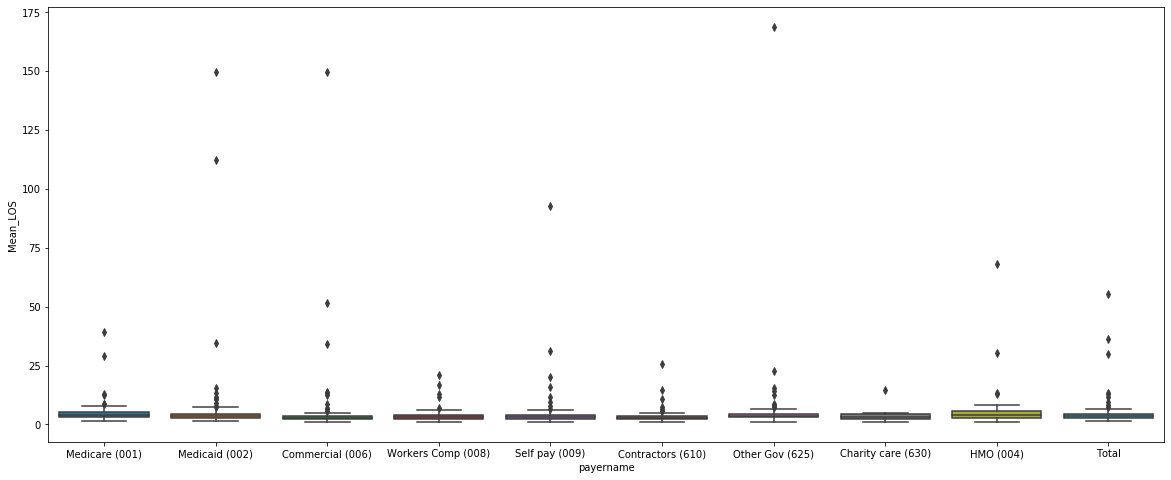

In [67]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="payername", y="Mean_LOS", data=df_AC)

Notice that the scale of the boxplot graphs when considering Mean Length of Stay relative to the payer type is very condensed.  This will be the result because there will be a few outliers, but generally speaking the length of stay will remain in the 2-6 day range. <br>
We can filter the data to exclude mean LOS beyond 10 days, for example to get a more discerning view. 

In [70]:
df_AC_filtered = df_AC[(df_AC['Mean_LOS'] < 8)]

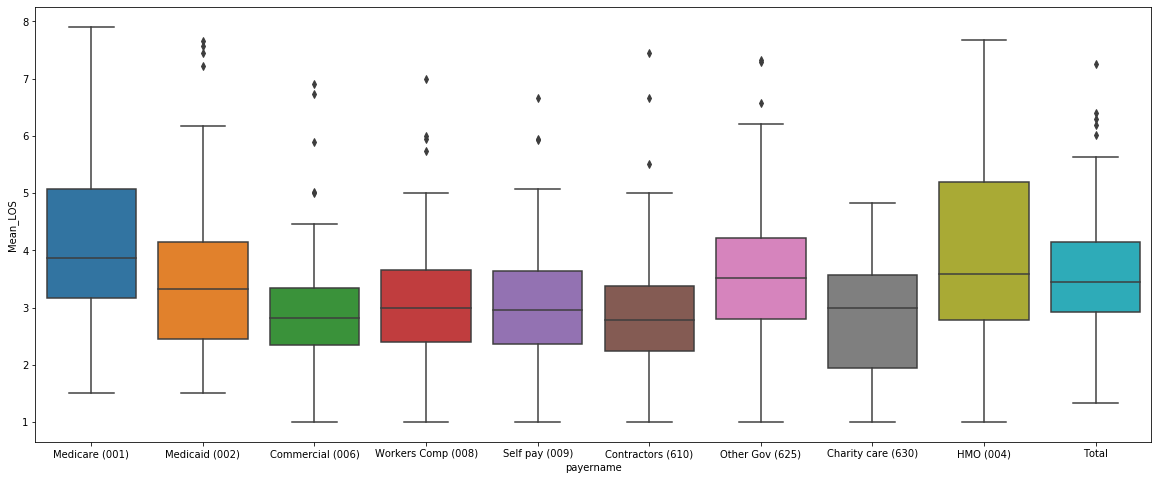

In [71]:
plt.figure(figsize=(20, 8))
sns.boxplot(x="payername", y="Mean_LOS", data=df_AC_filtered)

<h4> Another useful analysis in gaging the quality of the healthcare experience, is overall cost.  Both payers, employers, and paying patients would want to get as much value as possible out of their healthcare dollar. One way which we can consider this is to consider the <u> mean </u>.</h2>

#### It is interesting to consider the relative sizes of the interquartile range of the various boxplots.   Note that Commercial payer type has much narrower overall bounds that Medicare or HMO payer types for example.  This could suggest that Commercial and Contractor payer is overall far better at controlling length of stay, as they face greater financial incentive to reduce length of stay as opposed to government payer types. 

In [75]:
df_AC.groupby('Hospital_name').sum()

,Discharges,Total_days,Total_charges,Mean_LOS,Mean_Charge_per_Discharge,Mean_Charge_per_Day,Count_of_Weights
Hospital_name,,,,,,,
Arbor Health,380,1196,10898449.42,17.87,181352.55,62462.23,372
Astria Regional Medical Center,4562,18052,342307520.82,34.20,1297907.28,307541.36,4514
Astria Sunnyside Hospital,2922,8678,94101672.70,21.78,315932.22,104402.14,2896
Astria Toppenish Hospital,3392,12324,64224545.86,24.34,157330.37,50152.31,3388
CHI Franciscan Rehabilitation Hospital,1544,19848,78803082.64,113.43,439355.65,34962.09,1544
...,...,...,...,...,...,...,...
Virginia Mason Med Ctr,22120,123266,1453403963.64,54.08,646718.25,126917.77,21734
Virginia Mason Memorial Hospital,27026,94324,784137113.90,27.63,237724.14,67520.70,26712
WhidbeyHealth,2580,8346,63341876.50,20.02,153897.46,53800.23,2570


In this instance, the mean values will not be meaningful, therefore those columns should be dropped and then new values calculated from the recently summed items. 

In [76]:
df_AC_hospitals = df_AC.groupby('Hospital_name').sum()

In [77]:
df_AC_hospitals.drop(['Mean_LOS', 'Mean_Charge_per_Discharge','Mean_Charge_per_Day','Count_of_Weights'], axis=1, inplace=True)

In [78]:
df_AC_hospitals.head(100)

,Discharges,Total_days,Total_charges
Hospital_name,,,
Arbor Health,380,1196,10898449.42
Astria Regional Medical Center,4562,18052,342307520.82
Astria Sunnyside Hospital,2922,8678,94101672.70
Astria Toppenish Hospital,3392,12324,64224545.86
CHI Franciscan Rehabilitation Hospital,1544,19848,78803082.64
...,...,...,...
Virginia Mason Med Ctr,22120,123266,1453403963.64
Virginia Mason Memorial Hospital,27026,94324,784137113.90
WhidbeyHealth,2580,8346,63341876.50


Now that we have consolidated by hospital, we can recalculate some additional data points - Mean charge per discharge and Mean charge per total days.

In [79]:
df_AC_hospitals['Charges_per_disch'] = df_AC_hospitals.apply(lambda row: row.Total_charges / row.Discharges, axis=1)

In [80]:
df_AC_hospitals['Charges_per_day'] = df_AC_hospitals.apply(lambda row: row.Total_charges / row.Total_days, axis=1)

Plotting to consider the Charges_per_disch and Charges_per_day for the top 5 hospitals based on LOWEST Charges_per_discharge:

In [81]:
df_charges_disch = df_AC_hospitals.sort_values(by=['Charges_per_disch'], ascending=True)

In [82]:
df_plt = df_charges_disch.head(5)

In [83]:
df_plt.head(10)

,Discharges,Total_days,Total_charges,Charges_per_disch,Charges_per_day
Hospital_name,,,,,
East Adams Rural Healthcare,6,8,26492.00,4415.33,3311.50
Garfield County Public Hospital District,14,88,70473.00,5033.79,800.83
Odessa Memorial Healthcare Center,38,98,268151.98,7056.63,2736.24
Columbia Basin Hosp,260,732,1943316.14,7474.29,2654.80
Cascade Med Ctr,116,306,1052800.58,9075.87,3440.52


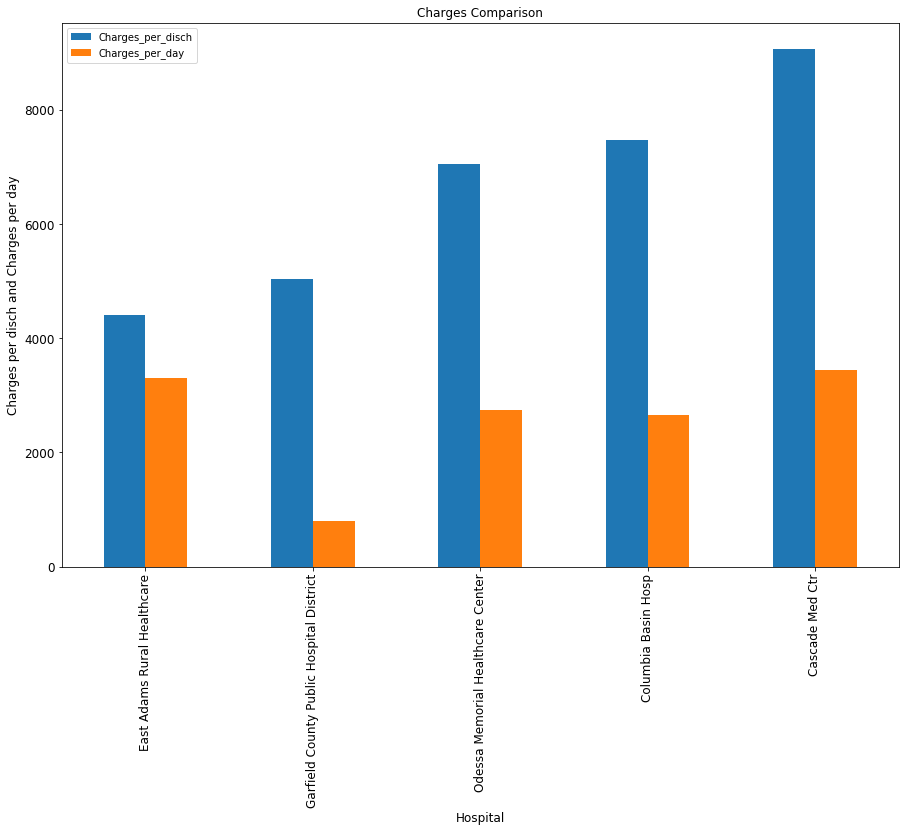

In [84]:
ax = df_plt[['Charges_per_disch','Charges_per_day']].plot(kind='bar', title ="Charges Comparison", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Hospital", fontsize=12)
ax.set_ylabel("Charges per disch and Charges per day", fontsize=12)
plt.show()

Curiously there is an inverse relationship described here.  Further investigation would be recommend in the future to be better understand the drivers related overall length of stay. 

In [85]:
df_charges_day = df_AC_hospitals.sort_values(by=['Charges_per_day'], ascending=True)

In [86]:
df_plt2 = df_charges_day.head(5)

In [87]:
df_plt2.head(10)

,Discharges,Total_days,Total_charges,Charges_per_disch,Charges_per_day
Hospital_name,,,,,
Columbia County Health System,330,11954,5547796.78,16811.51,464.10
Garfield County Public Hospital District,14,88,70473.00,5033.79,800.83
South Sound Behaviroal Hosptial,552,4510,9020000.00,16340.58,2000.00
Kaiser Permanente Central Hospital,776,2722,7190178.30,9265.69,2641.51
Columbia Basin Hosp,260,732,1943316.14,7474.29,2654.80


Overall, the total number of discharges for those hospitals that have the lowest Charges_per_day calculation of the Washington hospitals is quite quite small.  It would make far more sense to make the overall comparison based on the largest hosptials as measured by total volume of discharges. 

In [88]:
df_tot_discharges = df_AC_hospitals.sort_values(by=['Discharges'], ascending=False)

In [89]:
df_plt_disch = df_tot_discharges.head(5)

In [90]:
df_plt_disch.head()

,Discharges,Total_days,Total_charges,Charges_per_disch,Charges_per_day
Hospital_name,,,,,
Swedish First Hill-Ballard,79548,340442,4509615860.90,56690.50,13246.36
Prov Rgnl Med Ctr Everett,67052,315352,2965003123.14,44219.46,9402.20
Prov Sacred Heart Med Ctr and Childrens Hosp,62680,330946,3605333668.00,57519.68,10894.02
MultiCare Tacoma Gen Hosp - Allenmore,47902,227652,3411209439.04,71212.26,14984.32
St Joseph Med Ctr,46938,229790,3802601730.90,81013.29,16548.16


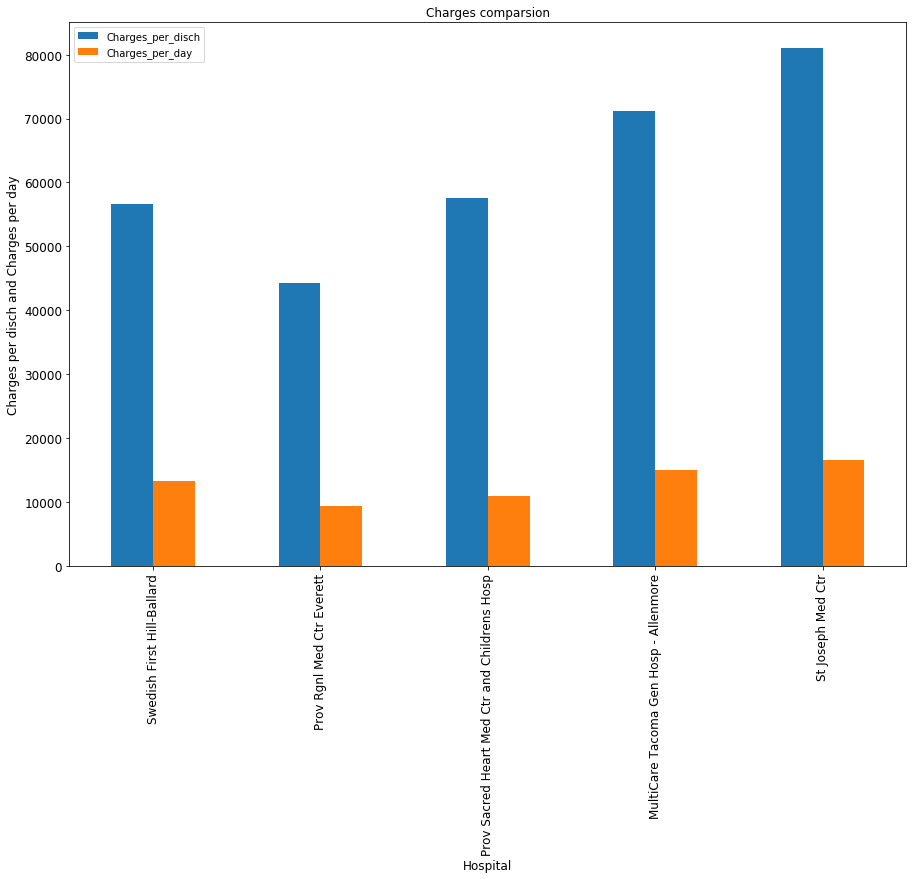

In [91]:
cx = df_plt_disch[['Charges_per_disch','Charges_per_day']].plot(kind='bar', title ="Charges comparsion", figsize=(15, 10), legend=True, fontsize=12)
cx.set_xlabel("Hospital", fontsize=12)
cx.set_ylabel("Charges per disch and Charges per day", fontsize=12)
plt.show()

This provides a more adequate assessment of the largest hospitals.  IT would seem that Providence Regional Medical center in Everett is doing the best job of containing overall charges of the top 5 hospitals as measured by total discharge volume. 

### This concludes the analysis coding for the IBM capstone project.  